# Retardo de grupo

### La función `group_delay` de `scipy.signal` se utiliza para calcular el retardo de grupo de un filtro digital. El retardo de grupo mide cuánto se retrasan las diferentes frecuencias a medida que pasan por el filtro. Esto es particularmente importante en aplicaciones donde la distorsión de fase puede afectar la señal, como en comunicaciones y procesamiento de señales.

### Argumentos de la Función

- **`(b, a)`**: Tupla que contiene los coeficientes del numerador (b) y del denominador (a) del filtro digital. Estos coeficientes definen la función de transferencia del filtro.
  
- **`w`**: Array de frecuencias en las que se evalúa el retardo de grupo. Se pueden pasar directamente las frecuencias en radianes por muestra a través del argumento `w`.

### Salida de la Función

La función `group_delay` devuelve dos valores:

- **`w_gd`**: Array de frecuencias en radianes por muestra en las cuales se calcula el retardo de grupo. Este array es similar al array `w` que se pasa como argumento.
- **`gd`**: Array que contiene los valores del retardo de grupo en las frecuencias correspondientes a `w_gd`. Estos valores están en unidades de tiempo de muestra.



```python
w_gd, gd = group_delay((b, a), w=w)


Coeficientes del numerador (b): [0.02862286 0.01025878 0.06164901 0.0445195  0.07079233 0.0445195
 0.06164901 0.01025878 0.02862286]
Coeficientes del denominador (a): [ 1.         -2.53401787  3.8182051  -3.43921174  2.1884081  -0.89666474
  0.2589235  -0.0386359   0.0038862 ]


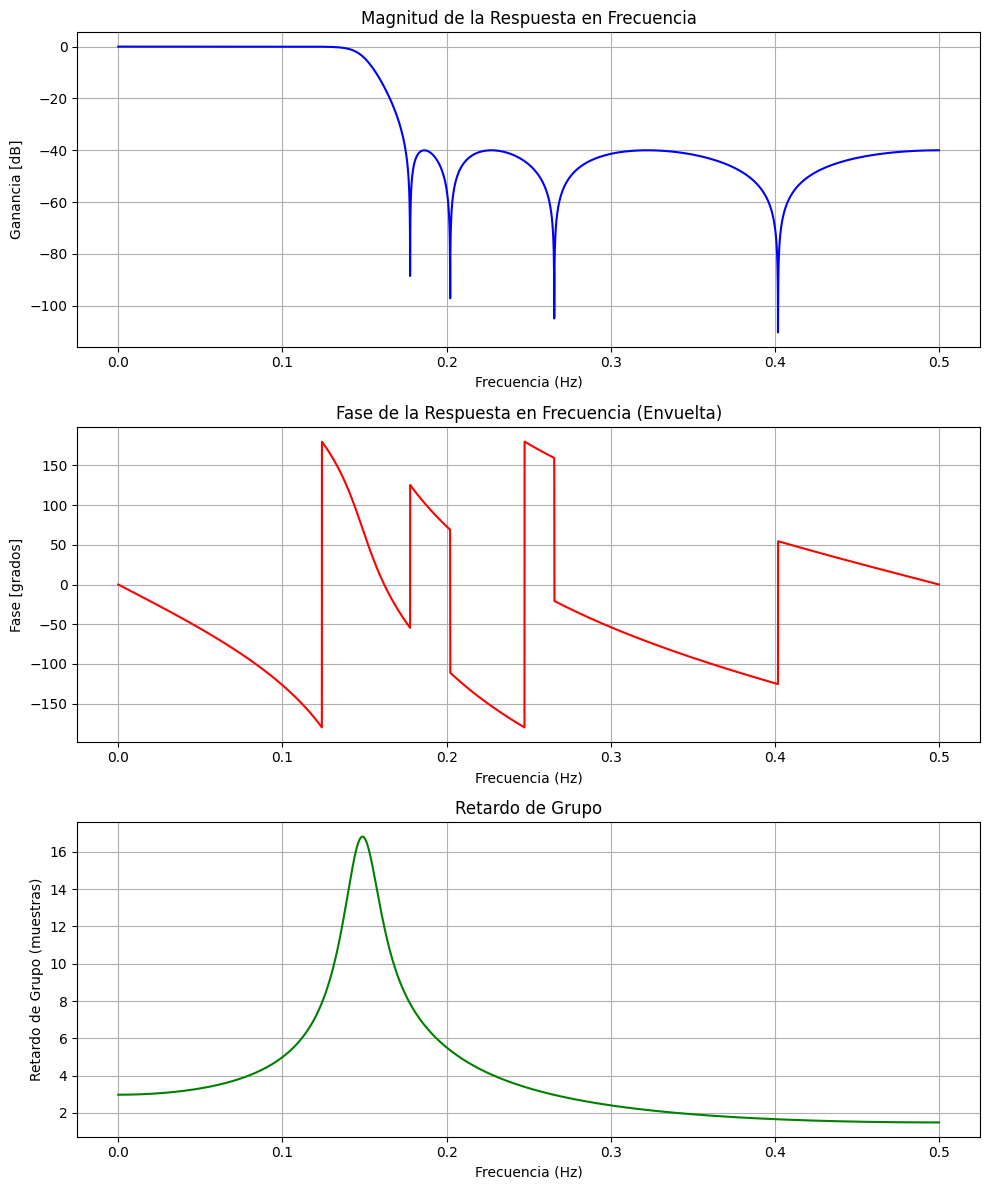

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.signal import butter, cheby1, cheby2, ellip, freqz, group_delay

def plot_frequency_response_and_group_delay(b, a):
    # Rango de frecuencias
    w, h = freqz(b, a, worN=8000)
    f = w / (2 * np.pi)  # Convertir de radianes/muestra a Hz

    # Calcular el retardo de grupo
    w_gd, gd = group_delay((b, a), w=w)

    # Graficar la respuesta en frecuencia (magnitud en dB y fase en grados)
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # Gráfico de magnitud en dB
    axs[0].plot(f, 20 * np.log10(np.abs(h)), 'b')
    axs[0].set_title('Magnitud de la Respuesta en Frecuencia')
    axs[0].set_xlabel('Frecuencia (Hz)')
    axs[0].set_ylabel('Ganancia [dB]')
    axs[0].grid()

    # Gráfico de fase en grados
    axs[1].plot(f, np.degrees(np.angle(h)), 'r')
    axs[1].set_title('Fase de la Respuesta en Frecuencia (Envuelta)')
    axs[1].set_xlabel('Frecuencia (Hz)')
    axs[1].set_ylabel('Fase [grados]')
    axs[1].grid()

    # Gráfico de retardo de grupo
    axs[2].plot(w_gd / (2 * np.pi), gd, 'g')
    axs[2].set_title('Retardo de Grupo')
    axs[2].set_xlabel('Frecuencia (Hz)')
    axs[2].set_ylabel('Retardo de Grupo (muestras)')
    axs[2].grid()

    plt.tight_layout()
    plt.show()

def main():
    # Leer parámetros desde un archivo JSON
    with open('filtro_parametros.json', 'r') as file:
        params = json.load(file)

    filter_type = params["tipo_filtro"]
    N = params["orden"]
    fc = params["fc"]
    
    if filter_type == "Butterworth":
        b, a = butter(N, fc, btype='low', analog=False)
    elif filter_type == "Chebyshev Tipo I":
        rp = params["rp"]
        b, a = cheby1(N, rp, fc, btype='low', analog=False)
    elif filter_type == "Chebyshev Tipo II":
        rs = params["rs"]
        b, a = cheby2(N, rs, fc, btype='low', analog=False)
    elif filter_type == "Elíptico":
        rp = params["rp"]
        rs = params["rs"]
        b, a = ellip(N, rp, rs, fc, btype='low', analog=False)
    else:
        print("Tipo de filtro no válido")
        return

    # Imprimir coeficientes
    print("Coeficientes del numerador (b):", b)
    print("Coeficientes del denominador (a):", a)

    # Graficar la respuesta en frecuencia y el retardo de grupo
    plot_frequency_response_and_group_delay(b, a)

if __name__ == "__main__":
    main()


---

***

## Método propuesto

Coeficientes del numerador (b): [0.02426115 0.09704461 0.14556692 0.09704461 0.02426115]
Coeficientes del denominador (a): [ 1.         -1.59771599  1.74592824 -1.0200446   0.30737576]


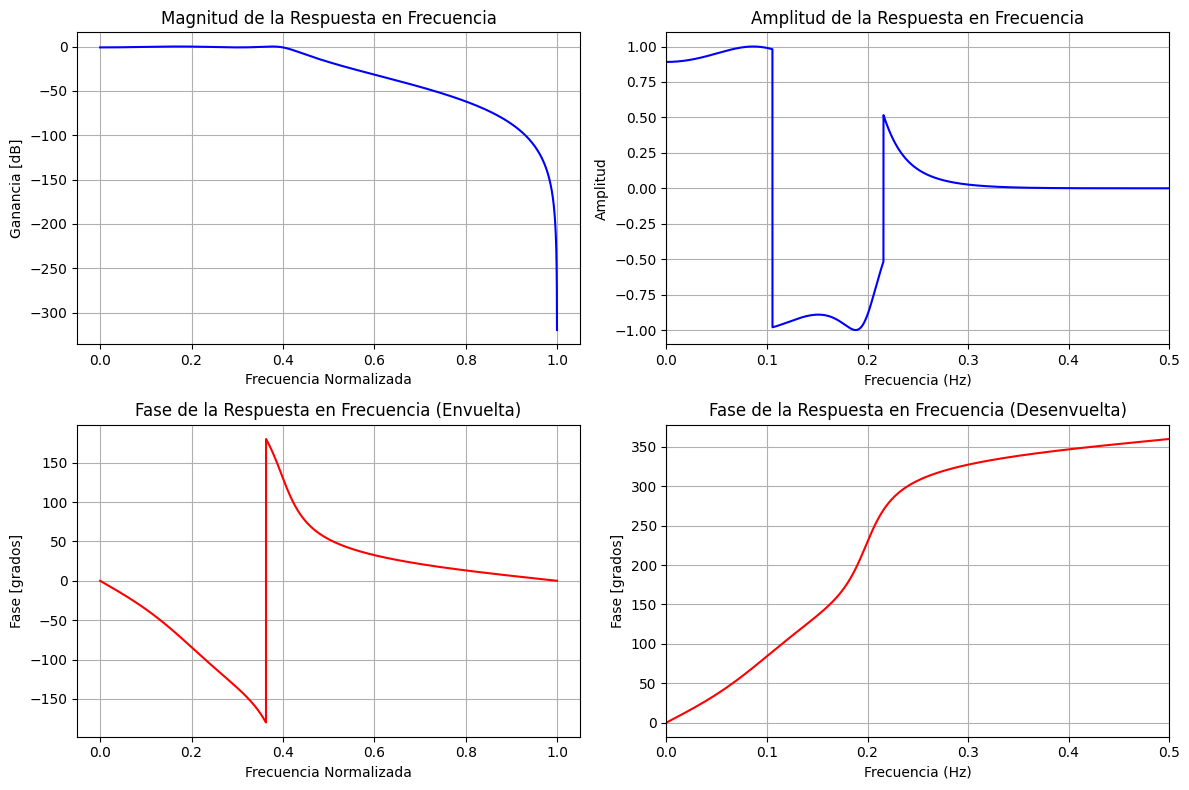

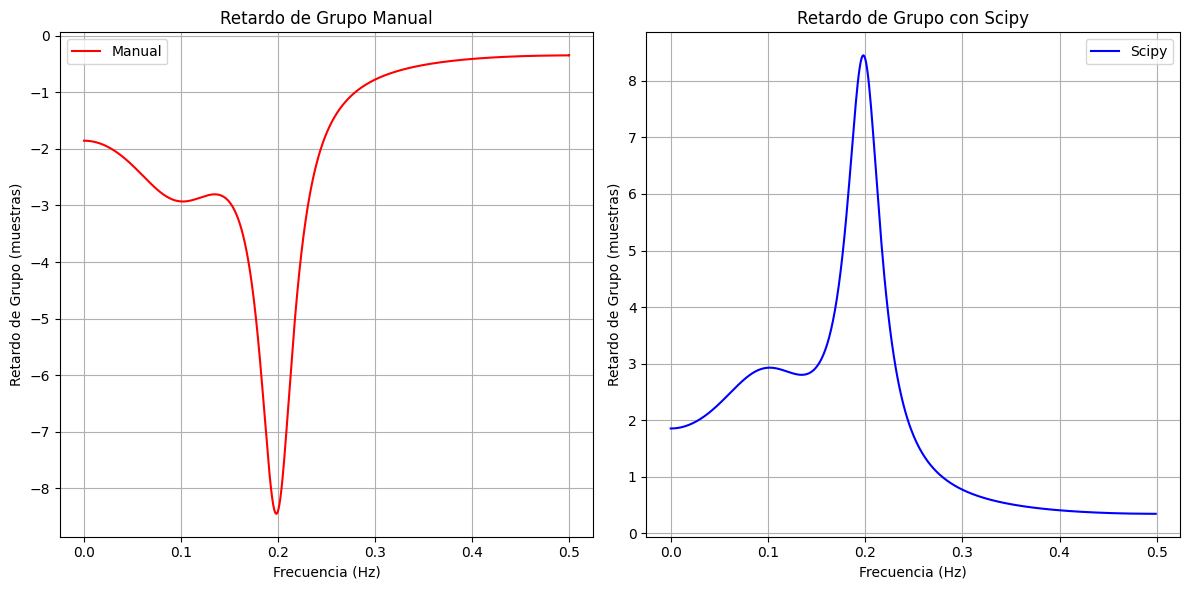

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.signal import butter, cheby1, cheby2, ellip, freqz, group_delay

def manual_group_delay(b, a, worN=8000):
    # Evaluar la respuesta en frecuencia
    w, h = freqz(b, a, worN=worN)
    
    # Calcular la fase de la respuesta en frecuencia
    phase = np.unwrap(np.angle(h))
    
    # Calcular la derivada de la fase respecto a la frecuencia
    dw = np.diff(w)
    dphase = np.diff(phase)
    
    # Retardo de grupo
    group_delay = -dphase / dw
    
    # Añadir el primer valor para igualar longitudes
    group_delay = np.concatenate(([group_delay[0]], group_delay))
    
    return w, group_delay

def plot_frequency_response(b, a):
    # Rango de frecuencias
    f = np.linspace(0, 0.5, 8000)  # Frecuencia de 0 a 0.5 (Nyquist)

    # Evaluar H(f) en z = e^(j2πf)
    z = np.exp(1j * 2 * np.pi * f)

    # Calcular la respuesta en frecuencia H(f) usando la ecuación de suma
    numerator = np.polyval(b, z**-1)
    denominator = np.polyval(a, z**-1)
    Hf = numerator / denominator

    # Desenvuelve la fase utilizando np.unwrap para evitar discontinuidades
    phase = np.angle(Hf)
    unwrapped_phase = np.unwrap(phase)

    # Ajustar la amplitud para admitir valores negativos
    amplitude = np.abs(Hf) * np.sign(np.real(Hf))  # Amplitud real, permitiendo negativos

    # Calcular el retardo de grupo manualmente
    dw = np.diff(2 * np.pi * f)  # Diferencia en frecuencias (en radianes)
    dphase = np.diff(unwrapped_phase)  # Diferencia en la fase
    group_delay_manual = -dphase / dw  # Retardo de grupo
    group_delay_manual = np.concatenate(([group_delay_manual[0]], group_delay_manual))  # Añadir el primer valor para igualar longitudes

    # Graficar la respuesta en frecuencia (magnitud en dB y fase en grados)
    w, h = freqz(b, a, worN=8000)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Gráfico de magnitud en dB
    axs[0, 0].plot(w / np.pi, 20 * np.log10(np.abs(h)), 'b')
    axs[0, 0].set_title('Magnitud de la Respuesta en Frecuencia')
    axs[0, 0].set_xlabel('Frecuencia Normalizada')
    axs[0, 0].set_ylabel('Ganancia [dB]')
    axs[0, 0].grid()

    # Gráfico de fase envuelta en grados
    axs[1, 0].plot(w / np.pi, np.degrees(np.angle(h)), 'r')
    axs[1, 0].set_title('Fase de la Respuesta en Frecuencia (Envuelta)')
    axs[1, 0].set_xlabel('Frecuencia Normalizada')
    axs[1, 0].set_ylabel('Fase [grados]')
    axs[1, 0].grid()

    # Gráfico de amplitud real
    axs[0, 1].plot(f, amplitude, 'b')
    axs[0, 1].set_title('Amplitud de la Respuesta en Frecuencia')
    axs[0, 1].set_xlabel('Frecuencia (Hz)')
    axs[0, 1].set_ylabel('Amplitud')
    axs[0, 1].grid()
    axs[0, 1].set_xlim([0, 0.5])

    # Gráfico de fase desenvuelta
    degrees = np.degrees(unwrapped_phase)
    axs[1, 1].plot(f, degrees, 'r')
    axs[1, 1].set_title('Fase de la Respuesta en Frecuencia (Desenvuelta)')
    axs[1, 1].set_xlabel('Frecuencia (Hz)')
    axs[1, 1].set_ylabel('Fase [grados]')
    axs[1, 1].grid()
    axs[1, 1].set_xlim([0, 0.5])

    plt.tight_layout()
    plt.show()

    # Calcular el retardo de grupo usando la función group_delay de scipy
    w_gd, gd_scipy = group_delay((b, a))

    # Graficar el retardo de grupo
    plt.figure(figsize=(12, 6))

    # Gráfico de retardo de grupo manual
    plt.subplot(1, 2, 1)
    plt.plot(w / (2 * np.pi), group_delay_manual, 'r', label='Manual')
    plt.title('Retardo de Grupo Manual')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Retardo de Grupo (muestras)')
    plt.grid()
    plt.legend()

    # Gráfico de retardo de grupo usando scipy
    plt.subplot(1, 2, 2)
    plt.plot(w_gd / (2 * np.pi), gd_scipy, 'b', label='Scipy')
    plt.title('Retardo de Grupo con Scipy')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Retardo de Grupo (muestras)')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Leer parámetros desde un archivo JSON
    with open('filtro_parametros.json', 'r') as file:
        params = json.load(file)

    filter_type = params["tipo_filtro"]
    N = params["orden"]
    fc = params["fc"]
    
    if filter_type == "Butterworth":
        b, a = butter(N, fc, btype='low', analog=False)
    elif filter_type == "Chebyshev Tipo I":
        rp = params["rp"]
        b, a = cheby1(N, rp, fc, btype='low', analog=False)
    elif filter_type == "Chebyshev Tipo II":
        rs = params["rs"]
        b, a = cheby2(N, rs, fc, btype='low', analog=False)
    elif filter_type == "Elíptico":
        rp = params["rp"]
        rs = params["rs"]
        b, a = ellip(N, rp, rs, fc, btype='low', analog=False)
    else:
        print("Tipo de filtro no válido")
        return

    # Imprimir coeficientes
    print("Coeficientes del numerador (b):", b)
    print("Coeficientes del denominador (a):", a)

    # Graficar la respuesta en frecuencia y la fase desenvuelta
    plot_frequency_response(b, a)

if __name__ == "__main__":
    main()


### Explicación 

El siguiente código define una función `manual_group_delay` calcula el retardo de grupo de un sistema dado a partir de sus coeficientes de filtro. El retardo de grupo se calcula evaluando la respuesta en frecuencia del sistema y derivando la fase respecto a la frecuencia.

$$  \tau_g(f) = -\frac{d\phi}{df}  $$


```python
def manual_group_delay(b, a, worN=8000):
    # Evaluar la respuesta en frecuencia
    w, h = freqz(b, a, worN=worN)
    
    # Calcular la fase de la respuesta en frecuencia
    phase = np.unwrap(np.angle(h))
    
    # Calcular la derivada de la fase respecto a la frecuencia
    dw = np.diff(w)
    dphase = np.diff(phase)
    
    # Retardo de grupo
    group_delay = -dphase / dw
    
    # Añadir el primer valor para igualar longitudes
    group_delay = np.concatenate(([group_delay[0]], group_delay))
    
    return w, group_delay


### Ejemplos particulares 


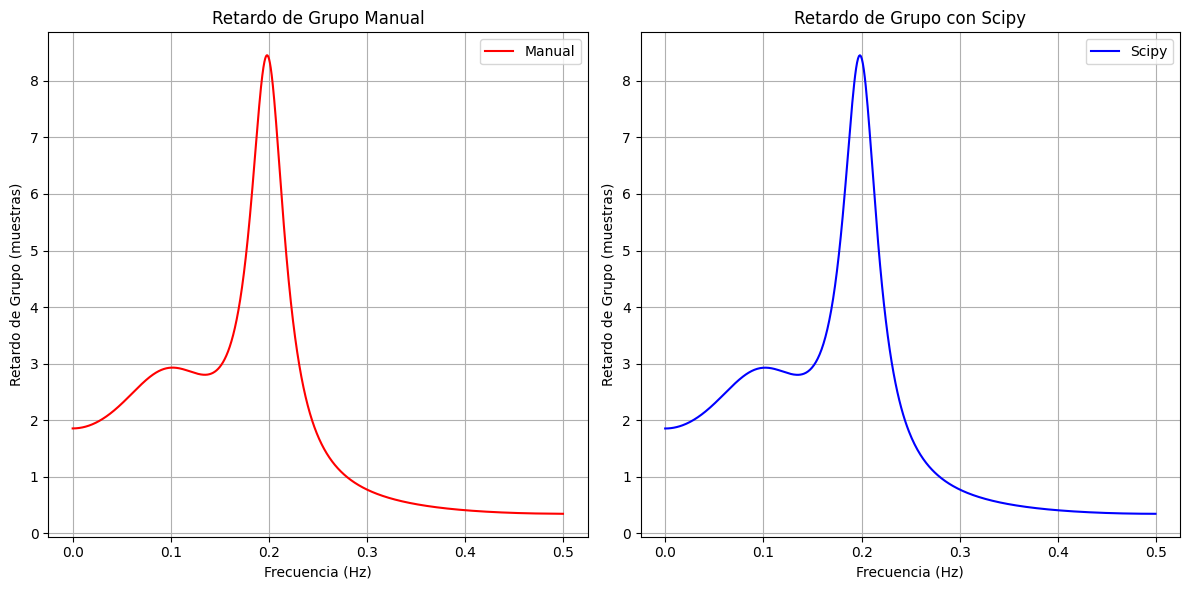

In [34]:
import numpy as np
from scipy.signal import freqz, group_delay

def manual_group_delay(b, a, worN=8000):
    # Evaluar la respuesta en frecuencia
    w, h = freqz(b, a, worN=worN)
    
    # Calcular la fase de la respuesta en frecuencia
    phase = np.unwrap(np.angle(h))
    
    # Calcular la derivada de la fase respecto a la frecuencia
    dw = np.diff(w)
    dphase = np.diff(phase)
    
    # Retardo de grupo
    group_delay = -dphase / dw
    
    # Añadir el primer valor para igualar longitudes
    group_delay = np.concatenate(([group_delay[0]], group_delay))
    
    return w, group_delay

# Ejemplo de uso
from scipy.signal import cheby1

# Parámetros del filtro
N = 4
rp = 1
fc = 0.4

# Diseño del filtro Chebyshev Tipo I
b, a = cheby1(N, rp, fc, btype='low', analog=False)

# Calcular el retardo de grupo manualmente
w, gd_manual = manual_group_delay(b, a)

# Calcular el retardo de grupo usando la función group_delay de scipy
w_gd, gd_scipy = group_delay((b, a))

# Graficar el retardo de grupo
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Gráfica del retardo de grupo manual
plt.subplot(1, 2, 1)
plt.plot(w / (2 * np.pi), gd_manual, 'r', label='Manual')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Retardo de Grupo (muestras)')
plt.title('Retardo de Grupo Manual')
plt.grid()
plt.legend()

# Gráfica del retardo de grupo usando scipy
plt.subplot(1, 2, 2)
plt.plot(w_gd / (2 * np.pi), gd_scipy, 'b', label='Scipy')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Retardo de Grupo (muestras)')
plt.title('Retardo de Grupo con Scipy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


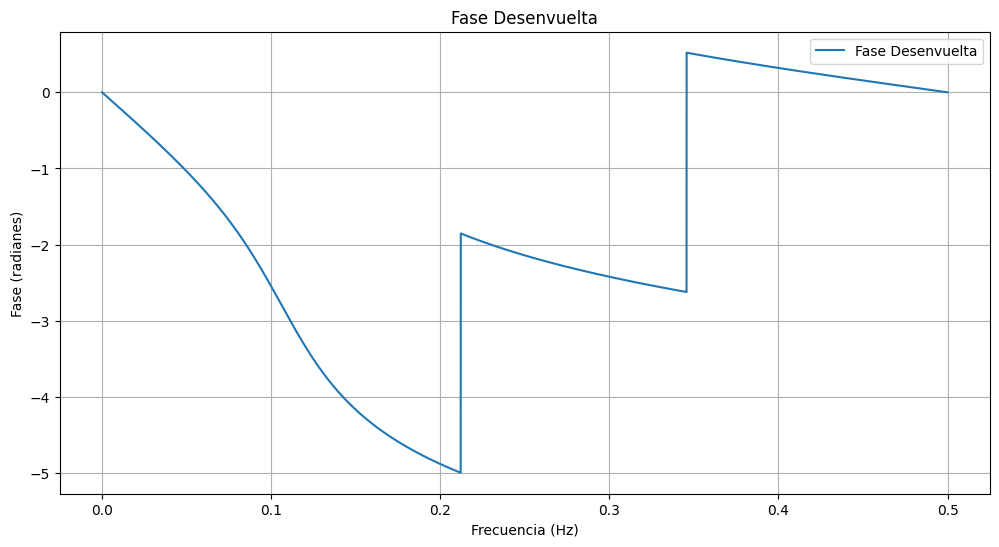

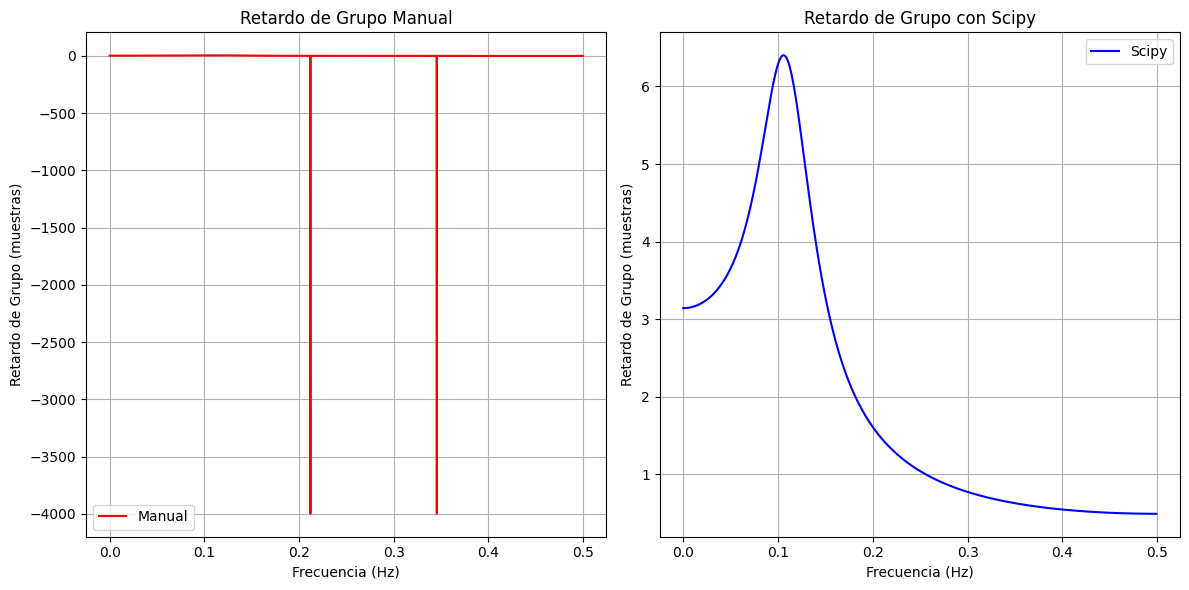

In [8]:
import numpy as np
from scipy.signal import freqz, group_delay, cheby2
import matplotlib.pyplot as plt

def manual_group_delay_from_phase(b, a, worN=8000):
    # Evaluar la respuesta en frecuencia
    w, h = freqz(b, a, worN=worN)
    
    # Calcular la fase de la respuesta en frecuencia
    phase = np.unwrap(np.angle(h))
    
    # Convertir la frecuencia angular a frecuencia en Hz
    f = w / (2 * np.pi)
    
    # Calcular la derivada de la fase respecto a la frecuencia en Hz
    df = np.gradient(f)
    dphase = np.gradient(phase)
    
    # Retardo de grupo según la ecuación proporcionada
    group_delay = -1 / (2 * np.pi) * dphase / df
    
    return f, phase, group_delay

# Parámetros del filtro
N = 4
rs = 40  # Atenuación en la banda de rechazo en dB
fc = 0.4

# Diseño del filtro Chebyshev Tipo II
b, a = cheby2(N, rs, fc, btype='low', analog=False)

# Calcular el retardo de grupo manualmente
f, phase, gd_manual = manual_group_delay_from_phase(b, a)

# Calcular el retardo de grupo usando la función group_delay de scipy
w_gd, gd_scipy = group_delay((b, a))
f_gd = w_gd / (2 * np.pi)

# Graficar la fase desenvuelta
plt.figure(figsize=(12, 6))
plt.plot(f, phase, label='Fase Desenvuelta')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Fase (radianes)')
plt.title('Fase Desenvuelta')
plt.grid()
plt.legend()
plt.show()

# Graficar el retardo de grupo
plt.figure(figsize=(12, 6))

# Gráfica del retardo de grupo manual
plt.subplot(1, 2, 1)
plt.plot(f, gd_manual, 'r', label='Manual')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Retardo de Grupo (muestras)')
plt.title('Retardo de Grupo Manual')
plt.grid()
plt.legend()

# Gráfica del retardo de grupo usando scipy
plt.subplot(1, 2, 2)
plt.plot(f_gd, gd_scipy, 'b', label='Scipy')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Retardo de Grupo (muestras)')
plt.title('Retardo de Grupo con Scipy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


### Usando la ecuación para D(w) :

$$ D(w) = -\frac{d}{dw} \arg H(e^{jw}) $$




Coeficientes del numerador (b): [0.02862286 0.01025878 0.06164901 0.0445195  0.07079233 0.0445195
 0.06164901 0.01025878 0.02862286]
Coeficientes del denominador (a): [ 1.         -2.53401787  3.8182051  -3.43921174  2.1884081  -0.89666474
  0.2589235  -0.0386359   0.0038862 ]


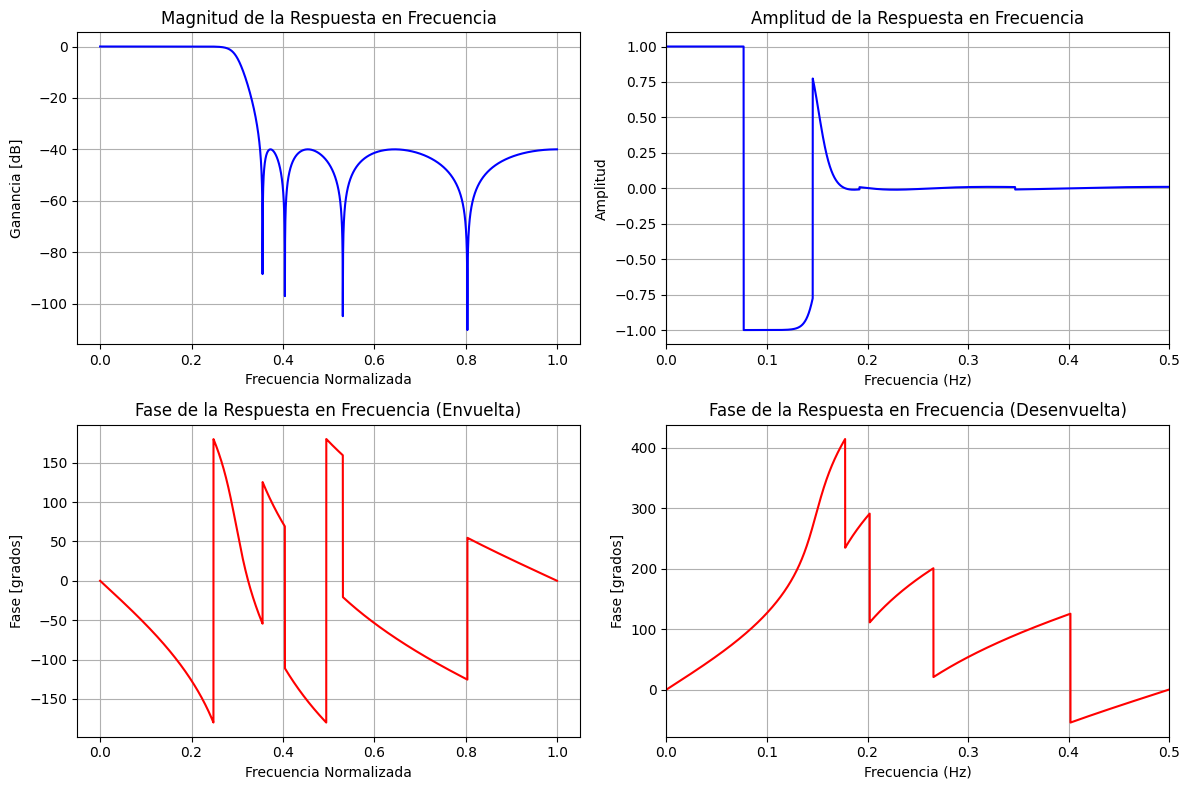

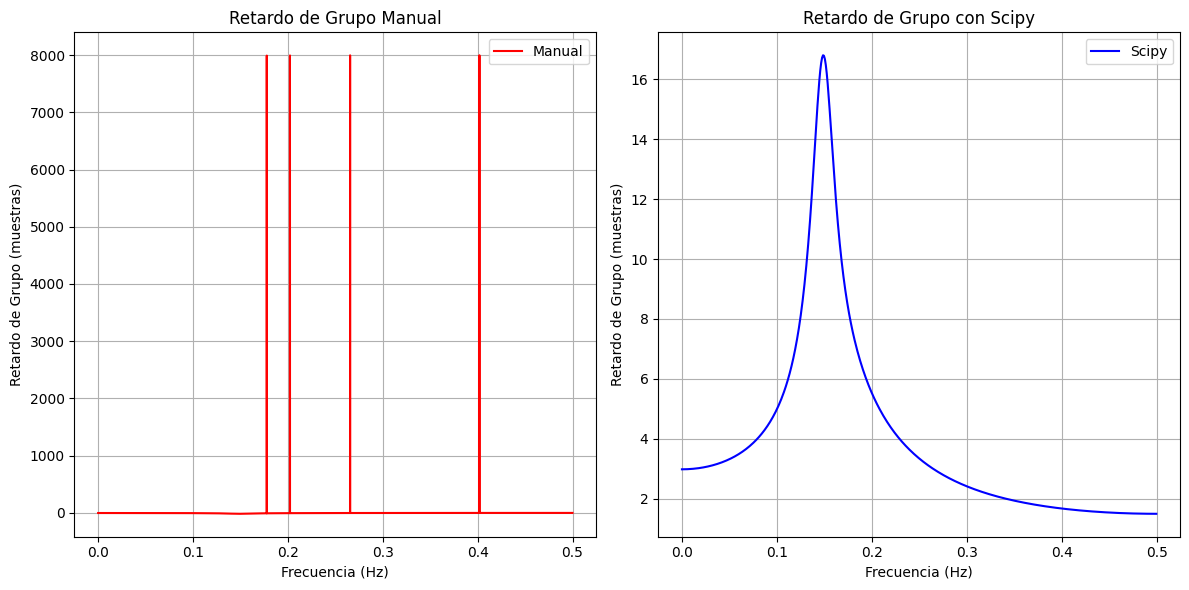

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, group_delay

def manual_group_delay(b, a, worN=8000):
    # Evaluar la respuesta en frecuencia
    w, h = freqz(b, a, worN=worN)
    
    # Calcular la fase de la respuesta en frecuencia
    phase = np.unwrap(np.angle(h))
    
    # Calcular la derivada de la fase respecto a la frecuencia
    dw = np.gradient(w)
    dphase = np.gradient(phase)
    
    # Retardo de grupo usando la ecuación D(w) = -d(phase)/dw
    group_delay = -dphase / dw
    
    return w, group_delay

def plot_frequency_response(b, a):
    # Rango de frecuencias
    f = np.linspace(0, 0.5, 8000)  # Frecuencia de 0 a 0.5 (Nyquist)

    # Evaluar H(f) en z = e^(j2πf)
    z = np.exp(1j * 2 * np.pi * f)

    # Calcular la respuesta en frecuencia H(f) usando la ecuación de suma
    numerator = np.polyval(b, z**-1)
    denominator = np.polyval(a, z**-1)
    Hf = numerator / denominator

    # Desenvuelve la fase utilizando np.unwrap para evitar discontinuidades
    phase = np.angle(Hf)
    unwrapped_phase = np.unwrap(phase)

    # Ajustar la amplitud para admitir valores negativos
    amplitude = np.abs(Hf) * np.sign(np.real(Hf))  # Amplitud real, permitiendo negativos

    # Calcular el retardo de grupo manualmente
    dw = np.diff(2 * np.pi * f)  # Diferencia en frecuencias (en radianes)
    dphase = np.diff(unwrapped_phase)  # Diferencia en la fase
    group_delay_manual = -dphase / dw  # Retardo de grupo
    group_delay_manual = np.concatenate(([group_delay_manual[0]], group_delay_manual))  # Añadir el primer valor para igualar longitudes

    # Graficar la respuesta en frecuencia (magnitud en dB y fase en grados)
    w, h = freqz(b, a, worN=8000)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Gráfico de magnitud en dB
    axs[0, 0].plot(w / np.pi, 20 * np.log10(np.abs(h)), 'b')
    axs[0, 0].set_title('Magnitud de la Respuesta en Frecuencia')
    axs[0, 0].set_xlabel('Frecuencia Normalizada')
    axs[0, 0].set_ylabel('Ganancia [dB]')
    axs[0, 0].grid()

    # Gráfico de fase envuelta en grados
    axs[1, 0].plot(w / np.pi, np.degrees(np.angle(h)), 'r')
    axs[1, 0].set_title('Fase de la Respuesta en Frecuencia (Envuelta)')
    axs[1, 0].set_xlabel('Frecuencia Normalizada')
    axs[1, 0].set_ylabel('Fase [grados]')
    axs[1, 0].grid()

    # Gráfico de amplitud real
    axs[0, 1].plot(f, amplitude, 'b')
    axs[0, 1].set_title('Amplitud de la Respuesta en Frecuencia')
    axs[0, 1].set_xlabel('Frecuencia (Hz)')
    axs[0, 1].set_ylabel('Amplitud')
    axs[0, 1].grid()
    axs[0, 1].set_xlim([0, 0.5])

    # Gráfico de fase desenvuelta
    degrees = np.degrees(unwrapped_phase)
    axs[1, 1].plot(f, degrees, 'r')
    axs[1, 1].set_title('Fase de la Respuesta en Frecuencia (Desenvuelta)')
    axs[1, 1].set_xlabel('Frecuencia (Hz)')
    axs[1, 1].set_ylabel('Fase [grados]')
    axs[1, 1].grid()
    axs[1, 1].set_xlim([0, 0.5])

    plt.tight_layout()
    plt.show()

    # Calcular el retardo de grupo usando la función group_delay de scipy
    w_gd, gd_scipy = group_delay((b, a))

    # Graficar el retardo de grupo
    plt.figure(figsize=(12, 6))

    # Gráfico de retardo de grupo manual
    plt.subplot(1, 2, 1)
    plt.plot(w / (2 * np.pi), group_delay_manual, 'r', label='Manual')
    plt.title('Retardo de Grupo Manual')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Retardo de Grupo (muestras)')
    plt.grid()
    plt.legend()

    # Gráfico de retardo de grupo usando scipy
    plt.subplot(1, 2, 2)
    plt.plot(w_gd / (2 * np.pi), gd_scipy, 'b', label='Scipy')
    plt.title('Retardo de Grupo con Scipy')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Retardo de Grupo (muestras)')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Leer parámetros desde un archivo JSON
    with open('filtro_parametros.json', 'r') as file:
        params = json.load(file)

    filter_type = params["tipo_filtro"]
    N = params["orden"]
    fc = params["fc"]
    
    if filter_type == "Butterworth":
        b, a = butter(N, fc, btype='low', analog=False)
    elif filter_type == "Chebyshev Tipo I":
        rp = params["rp"]
        b, a = cheby1(N, rp, fc, btype='low', analog=False)
    elif filter_type == "Chebyshev Tipo II":
        rs = params["rs"]
        b, a = cheby2(N, rs, fc, btype='low', analog=False)
    elif filter_type == "Elíptico":
        rp = params["rp"]
        rs = params["rs"]
        b, a = ellip(N, rp, rs, fc, btype='low', analog=False)
    else:
        print("Tipo de filtro no válido")
        return

    # Imprimir coeficientes
    print("Coeficientes del numerador (b):", b)
    print("Coeficientes del denominador (a):", a)

    # Graficar la respuesta en frecuencia y la fase desenvuelta
    plot_frequency_response(b, a)

if __name__ == "__main__":
    main()


Coeficientes del numerador (b): [0.02862286 0.01025878 0.06164901 0.0445195  0.07079233 0.0445195
 0.06164901 0.01025878 0.02862286]
Coeficientes del denominador (a): [ 1.         -2.53401787  3.8182051  -3.43921174  2.1884081  -0.89666474
  0.2589235  -0.0386359   0.0038862 ]


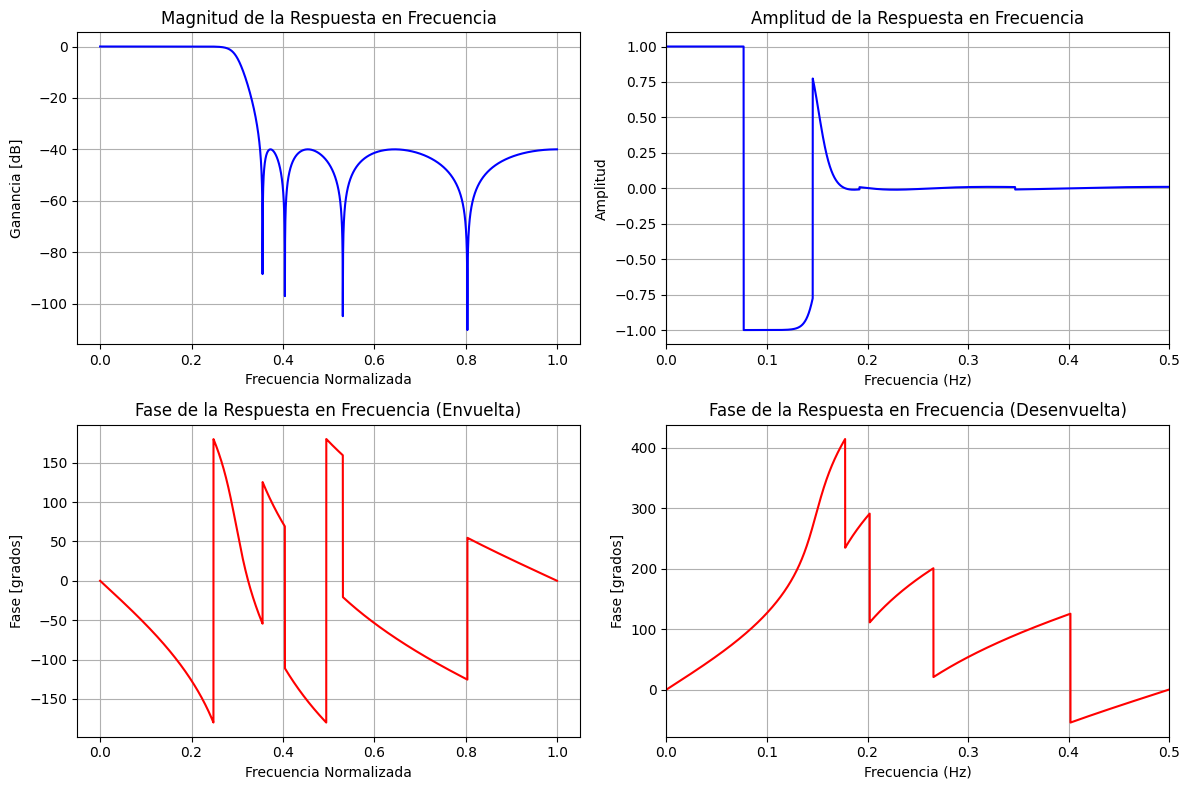

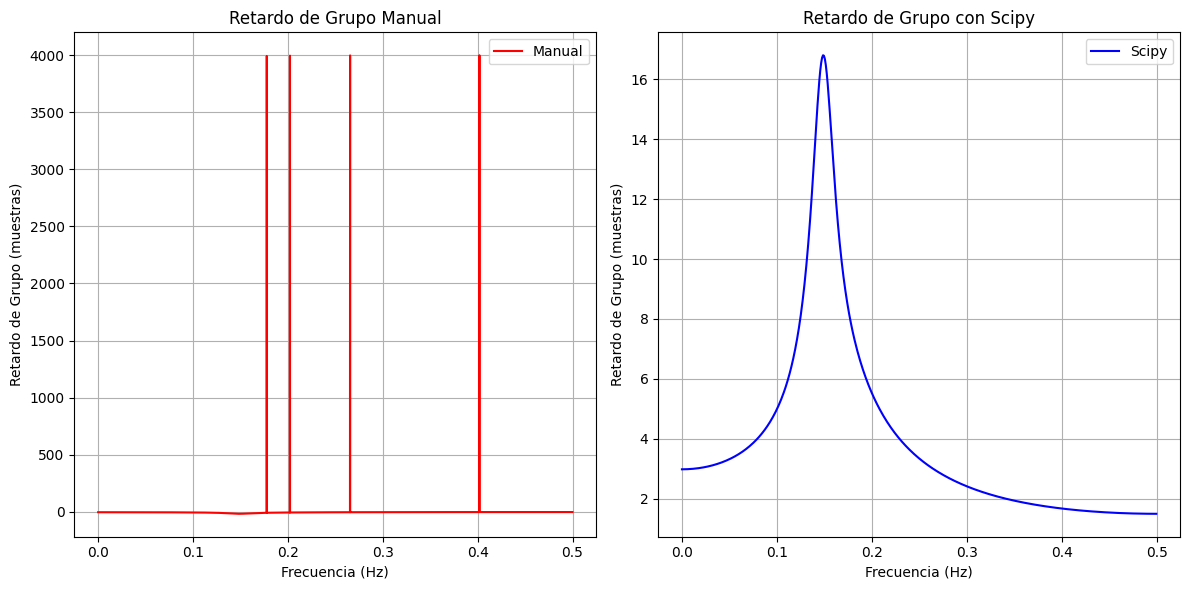

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, group_delay

def manual_group_delay(b, a, worN=8000):
    
    # D(w) = -d(arg(H(e^jw))) / dw
    
    
    # Evaluar la respuesta en frecuencia
    w, h = freqz(b, a, worN=worN)
    
    # Calcular la fase de la respuesta en frecuencia
    phase = np.unwrap(np.angle(h))
    
    # Calcular la derivada de la fase respecto a la frecuencia
    dw = np.gradient(w)
    dphase = np.gradient(phase)
    
    # Retardo de grupo usando la ecuación D(w) = -d(phase)/dw
    group_delay = -dphase / dw
    
    return w, group_delay

def plot_frequency_response(b, a):
    
    # Rango de frecuencias
    f = np.linspace(0, 0.5, 8000)  # Frecuencia de 0 a 0.5 (Nyquist)

    # Evaluar H(f) en z = e^(j2πf)
    z = np.exp(1j * 2 * np.pi * f)

    # Calcular la respuesta en frecuencia H(f) usando la ecuación de suma
    numerator = np.polyval(b, z**-1)
    denominator = np.polyval(a, z**-1)
    Hf = numerator / denominator

    # Desenvuelve la fase utilizando np.unwrap para evitar discontinuidades
    phase = np.angle(Hf)
    unwrapped_phase = np.unwrap(phase)

    # Ajustar la amplitud para admitir valores negativos
    amplitude = np.abs(Hf) * np.sign(np.real(Hf))  # Amplitud real, permitiendo negativos

    # Calcular el retardo de grupo manualmente
    dw = np.gradient(2 * np.pi * f)  # Diferencia en frecuencias (en radianes)
    dphase = np.gradient(unwrapped_phase)  # Diferencia en la fase
    group_delay_manual = -dphase / dw  # Retardo de grupo

    # Graficar la respuesta en frecuencia (magnitud en dB y fase en grados)
    w, h = freqz(b, a, worN=8000)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Gráfico de magnitud en dB
    axs[0, 0].plot(w / np.pi, 20 * np.log10(np.abs(h)), 'b')
    axs[0, 0].set_title('Magnitud de la Respuesta en Frecuencia')
    axs[0, 0].set_xlabel('Frecuencia Normalizada')
    axs[0, 0].set_ylabel('Ganancia [dB]')
    axs[0, 0].grid()

    # Gráfico de fase envuelta en grados
    axs[1, 0].plot(w / np.pi, np.degrees(np.angle(h)), 'r')
    axs[1, 0].set_title('Fase de la Respuesta en Frecuencia (Envuelta)')
    axs[1, 0].set_xlabel('Frecuencia Normalizada')
    axs[1, 0].set_ylabel('Fase [grados]')
    axs[1, 0].grid()

    # Gráfico de amplitud real
    axs[0, 1].plot(f, amplitude, 'b')
    axs[0, 1].set_title('Amplitud de la Respuesta en Frecuencia')
    axs[0, 1].set_xlabel('Frecuencia (Hz)')
    axs[0, 1].set_ylabel('Amplitud')
    axs[0, 1].grid()
    axs[0, 1].set_xlim([0, 0.5])

    # Gráfico de fase desenvuelta
    degrees = np.degrees(unwrapped_phase)
    axs[1, 1].plot(f, degrees, 'r')
    axs[1, 1].set_title('Fase de la Respuesta en Frecuencia (Desenvuelta)')
    axs[1, 1].set_xlabel('Frecuencia (Hz)')
    axs[1, 1].set_ylabel('Fase [grados]')
    axs[1, 1].grid()
    axs[1, 1].set_xlim([0, 0.5])

    plt.tight_layout()
    plt.show()

    # Calcular el retardo de grupo usando la función group_delay de scipy
    w_gd, gd_scipy = group_delay((b, a))

    # Graficar el retardo de grupo
    plt.figure(figsize=(12, 6))

    # Gráfico de retardo de grupo manual
    plt.subplot(1, 2, 1)
    plt.plot(w / (2 * np.pi), group_delay_manual, 'r', label='Manual')
    plt.title('Retardo de Grupo Manual')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Retardo de Grupo (muestras)')
    plt.grid()
    plt.legend()

    # Gráfico de retardo de grupo usando scipy
    plt.subplot(1, 2, 2)
    plt.plot(w_gd / (2 * np.pi), gd_scipy, 'b', label='Scipy')
    plt.title('Retardo de Grupo con Scipy')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Retardo de Grupo (muestras)')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Leer parámetros desde un archivo JSON
    with open('filtro_parametros.json', 'r') as file:
        params = json.load(file)

    filter_type = params["tipo_filtro"]
    N = params["orden"]
    fc = params["fc"]
    
    if filter_type == "Butterworth":
        b, a = butter(N, fc, btype='low', analog=False)
    elif filter_type == "Chebyshev Tipo I":
        rp = params["rp"]
        b, a = cheby1(N, rp, fc, btype='low', analog=False)
    elif filter_type == "Chebyshev Tipo II":
        rs = params["rs"]
        b, a = cheby2(N, rs, fc, btype='low', analog=False)
    elif filter_type == "Elíptico":
        rp = params["rp"]
        rs = params["rs"]
        b, a = ellip(N, rp, rs, fc, btype='low', analog=False)
    else:
        print("Tipo de filtro no válido")
        return

    # Imprimir coeficientes
    print("Coeficientes del numerador (b):", b)
    print("Coeficientes del denominador (a):", a)

    # Graficar la respuesta en frecuencia y la fase desenvuelta
    plot_frequency_response(b, a)

if __name__ == "__main__":
    main()
